In [1]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import geopandas as gpd 
%matplotlib inline

In [2]:
dict_ine_name= {'02': 'Albacete',
 '03': 'Alicante/Alacant',
 '04': 'Almería',
 '01': 'Araba/Álava',
 '33': 'Asturias',
 '05': 'Ávila',
 '06': 'Badajoz',
 '07': 'Balears Illes',
 '08': 'Barcelona',
 '48': 'Bizkaia',
 '09': 'Burgos',
 '10': 'Cáceres',
 '11': 'Cádiz',
 '39': 'Cantabria',
 '12': 'Castellón/Castelló',
 '13': 'Ciudad Real',
 '14': 'Córdoba',
 '15': 'Coruña A',
 '16': 'Cuenca',
 '20': 'Gipuzkoa',
 '17': 'Girona',
 '18': 'Granada',
 '19': 'Guadalajara',
 '21': 'Huelva',
 '22': 'Huesca',
 '23': 'Jaén',
 '24': 'León',
 '25': 'Lleida',
 '27': 'Lugo',
 '28': 'Madrid',
 '29': 'Málaga',
 '30': 'Murcia',
 '31': 'Navarra',
 '32': 'Ourense',
 '34': 'Palencia',
 '35': 'Palmas Las',
 '36': 'Pontevedra',
 '26': 'Rioja La',
 '37': 'Salamanca',
 '38': 'Santa Cruz de Tenerife',
 '40': 'Segovia',
 '41': 'Sevilla',
 '42': 'Soria',
 '43': 'Tarragona',
 '44': 'Teruel',
 '45': 'Toledo',
 '46': 'Valencia/València',
 '47': 'Valladolid',
 '49': 'Zamora',
 '50': 'Zaragoza',
 '51': 'Ceuta',
 '52': 'Melilla'}
gdf = gpd.read_file('Map/Provinces.shp', encoding='utf-8') 

In [3]:
def preprocess(path):
    dtypes = {"Origen":str,
              "Destino":str,
              "Año":str,
              "Mes":str,
              "Día":str,
              "Periodo":str,
              "Modo":str,
              "Distancia":str,
              "Residencia":str,
              "Actividad_Origen":str,
              "Actividad_Destino":str,
              "Viajeros":str,
              "Viajeros-km":str}
    df = pd.read_csv(path, encoding = "utf-8", dtype=dtypes)
#    df = pd.read_csv(path, delimiter=",", encoding = "utf-8",dtype= dtypes)
    df['Viajeros'] = df['Viajeros'].str.replace(r'\,','').astype(float)
    df['Viajeros-km'] = df['Viajeros-km'].str.replace(r'\,','').astype(float)
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df

In [4]:
def preprocess2(path):
    col = ['Origen','Destino', 'Año', 'Mes', 'Día', 'Periodo', 'Modo', 'Distancia', 'Residencia', 'Actividad_Origen',
           'Actividad_Destino', 'Viajeros', 'Viajeros-km']
    df = pd.read_csv(path, delimiter=",", names = col)
    df['Viajeros'] = df['Viajeros'].apply(lambda z: float(z.replace(',', '.')))
    df['Viajeros-km'] = df['Viajeros-km'].apply(lambda z: float(z.replace(',', '.')))
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df

In [5]:
def get_destino_distribution(df,Origen):
    destino_distribution = df[df.Origen == Origen].groupby('Destino2').Viajeros.sum().to_frame('weight')
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame([str(z).zfill(2) for z in range(1, 53)], columns=['Destino2'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='Destino2', how='outer')
    destino_distribution.weight.fillna(0, inplace=True)
    if destino_distribution['weight'].sum() == 0:
        destino_distribution['norm_weight'] = 1 / len(destino_distribution)
    else:
        destino_distribution['norm_weight'] = destino_distribution['weight'] / destino_distribution['weight'].sum()
    destino_distribution.sort_values('norm_weight', ascending=False, inplace=True)
    return destino_distribution

In [6]:
def plot_signiture(df):
    plt.figure()
    rank = list(range(1, 53))
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        destino = str(i).zfill(2)
        destino_distributions[destino] = get_destino_distribution(df,Origen=destino)
        destino_norm_distributions[destino] = destino_distributions[destino].norm_weight

    plt.subplot(1, 1, 1)
    for i in range(1, 53):
        destino_distribution = destino_distributions[str(i).zfill(2)]
        plt.plot(rank, destino_distribution.norm_weight, color='blue', alpha=0.5)
    # plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction')
    plt.tight_layout()


In [7]:
def get_distance_matrix(df):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        destino = str(i).zfill(2)
        destino_distributions[destino] = get_destino_distribution(df, Origen=destino)
        destino_norm_distributions[destino] = destino_distributions[destino].norm_weight

    
    dist_mat = []
    destino_dist_avg = {}
    for i in range(1, 53):
        destino_i = str(i).zfill(2)
        array_i = []
        for j in range(1, 53):
            destino_j = str(j).zfill(2)
            array_i.append(jensenshannon(destino_norm_distributions[destino_i], 
                                         destino_norm_distributions[destino_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[destino_i] = np.nanmean(array_i)
    return dist_mat

In [8]:
def plot_distance_matrix(dist_mat):
    plt.figure(figsize=(14, 14))
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], rotation=90)
    plt.yticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)])
    plt.title('distance matrix')

In [9]:
def plot_dendrogram(dist_mat):
    plt.figure(figsize=(12, 6))
    x = linkage(dist_mat,'complete')
    g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, leaf_font_size =14)
    plt.tight_layout()
    plt.savefig('dendrogram.pdf')
   

In [47]:
def clusters(dist_mat):
    x = linkage(dist_mat,'complete')
    g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, leaf_font_size =14, no_plot = True)
    cluster_dict = {}
    for clust in g['color_list']:
        ind = [i for i, j in enumerate(g['color_list']) if j == clust]
        cluster_dict[clust]= [g['ivl'][i] for i in ind]
                       
    return(cluster_dict)

In [48]:
def clustered_cities(dist_mat):
    cluster_groups = clusters(dist_mat).keys()
    group_cord = []
    for clust in cluster_groups:
        cities = clusters(dist_mat)[clust]
        group_cord.append([list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities])
    return(group_cord)    
    

In [52]:
def plot_clustered_cities(group, title_name):
    colors = ['r','b','y','g','gray','orange','purple']
    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(8,6))
    ax.set_title(title_name)
    for g, c in zip(group,colors):
        gdf[gdf.CPRO.isin(g)].plot(ax=ax, color=c)
    

<ipython-input-9-cfa9fcbe153f>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,'complete')
<ipython-input-10-4e0c8883f326>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,'complete')


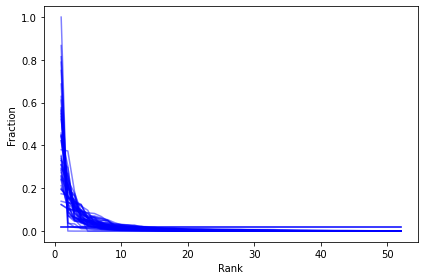

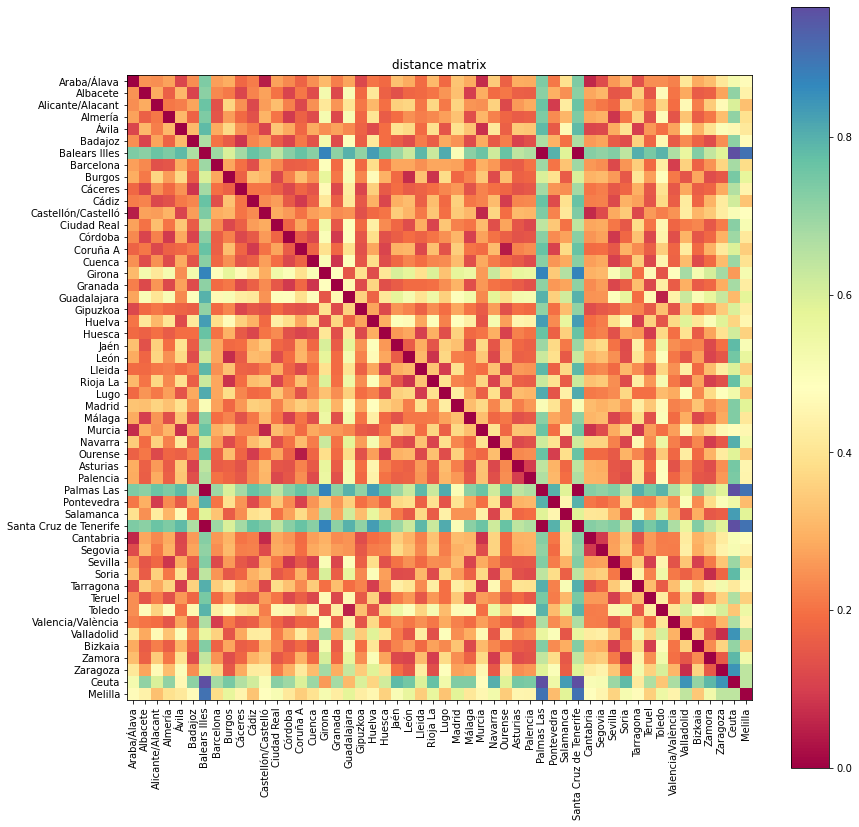

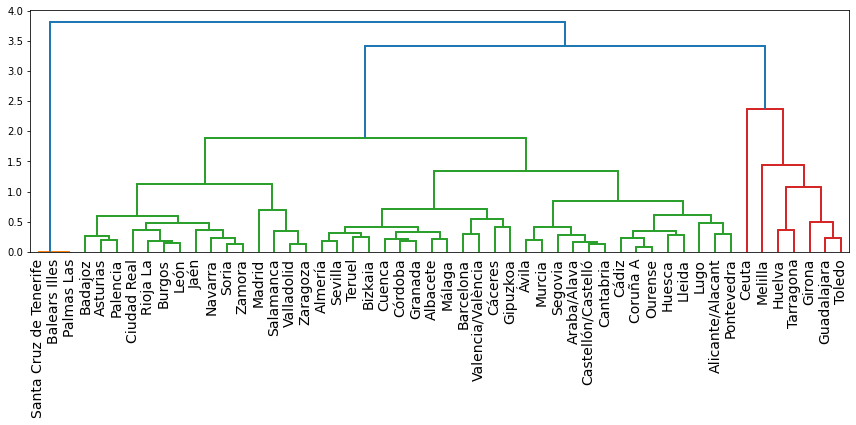

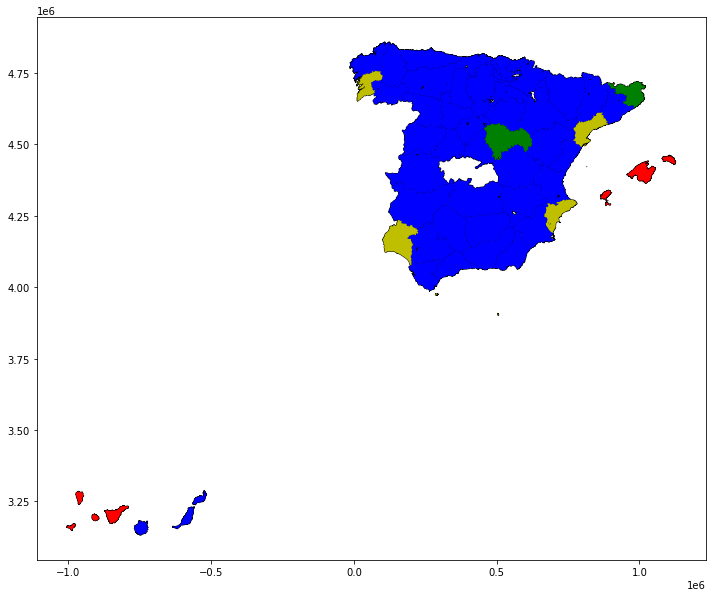

In [37]:
path = "July/ET_J10.csv" #first of Auguest
df = preprocess(path)
plot_signiture(df)
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
plot_dendrogram(dist_mat)
group = clustered_cities(dist_mat)
plot_clustered_cities(group)

<ipython-input-9-cfa9fcbe153f>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,'complete')
<ipython-input-10-4e0c8883f326>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,'complete')


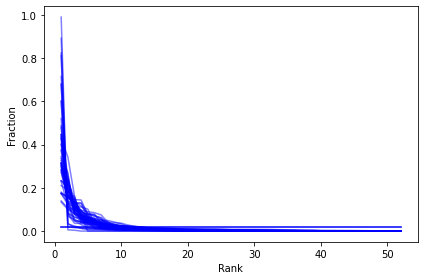

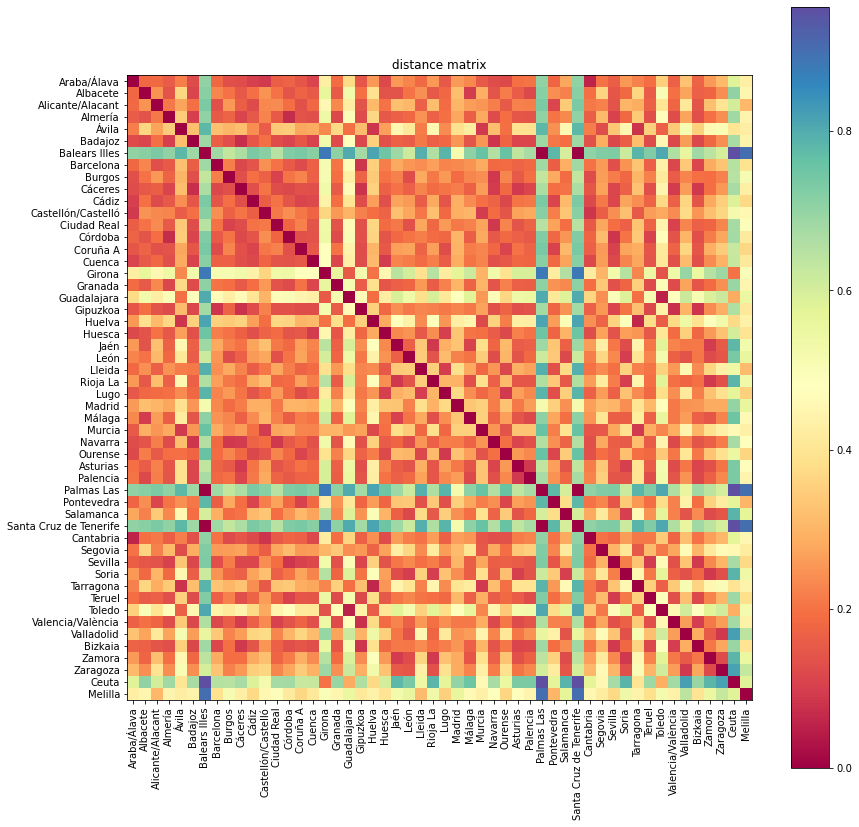

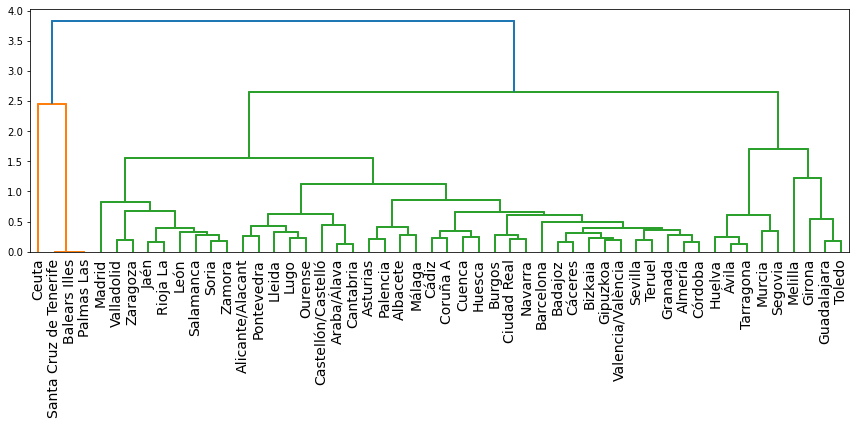

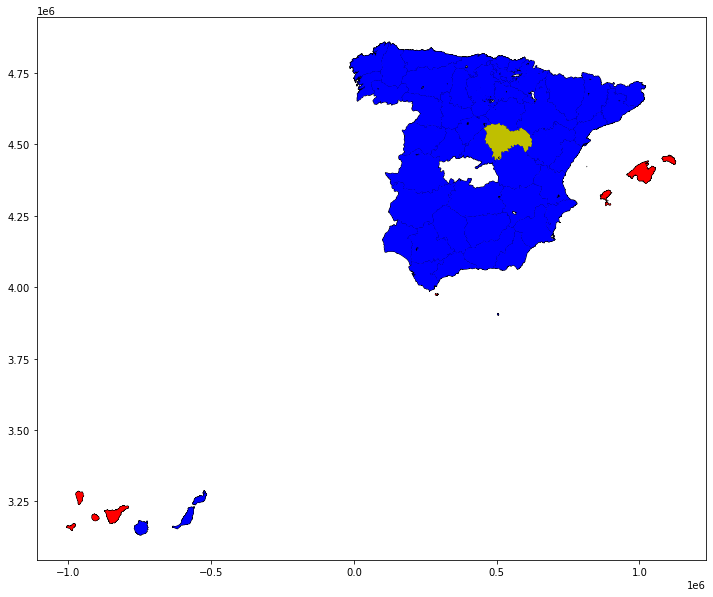

In [38]:
path = "July/ET_J09.csv" #31th of July
df = preprocess(path)
plot_signiture(df)
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
plot_dendrogram(dist_mat)
group = clustered_cities(dist_mat)
plot_clustered_cities(group)

In [50]:
path_1 = "July/ET_J10.csv" #first of Auguest
df_1 = preprocess(path_1)
dist_mat_1 = get_distance_matrix(df_1)
group_1 = clustered_cities(dist_mat_1)

path_31 = "July/ET_J09.csv" #31th of July
df_31 = preprocess(path_31)
dist_mat_31 = get_distance_matrix(df_31)
group_31 = clustered_cities(dist_mat_31)


path_wed = "July/ET_J09.csv" #average Wednesday July/Auguest
df_wed = preprocess(path_wed)
dist_mat_wed = get_distance_matrix(df_wed)
group_wed = clustered_cities(dist_mat_wed)


path_sat = "July/ET_J05.csv" #average Saturday July/Auguest
df_sat = preprocess(path_sat)
dist_mat_sat = get_distance_matrix(df_sat)
group_sat = clustered_cities(dist_mat_sat)

path_sun = "July/ET_J06.csv" #average Sunday July/Auguest
df_sun = preprocess(path_sun)
dist_mat_sun = get_distance_matrix(df_sun)
group_sun = clustered_cities(dist_mat_sun)

<ipython-input-47-635462cc1e90>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,'complete')


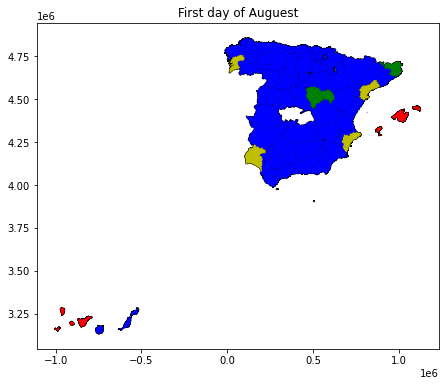

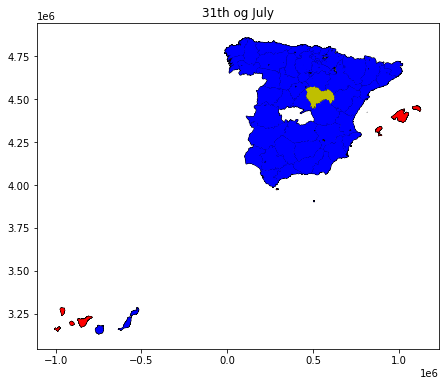

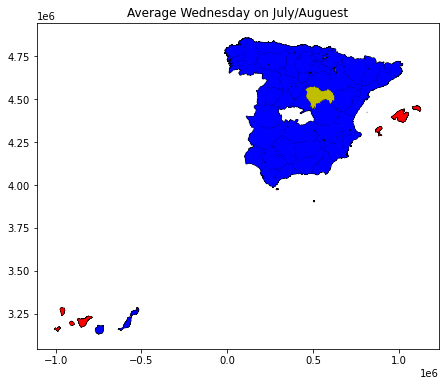

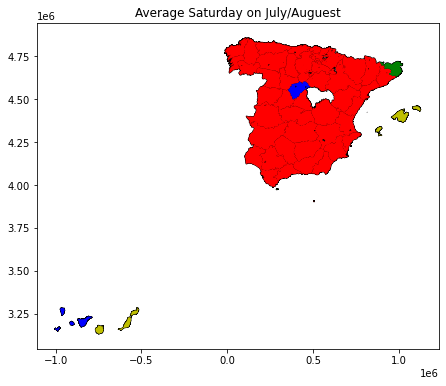

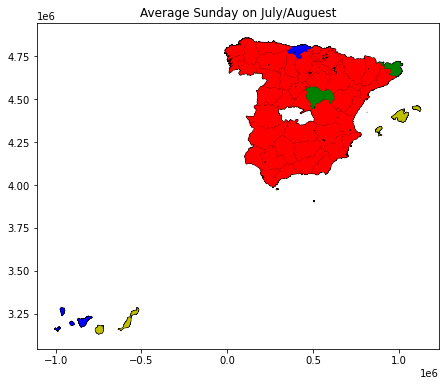

In [54]:
plot_clustered_cities(group_1, "First day of Auguest")
plot_clustered_cities(group_31, "31th og July")
plot_clustered_cities(group_wed, "Average Wednesday on July/Auguest")
plot_clustered_cities(group_sat, "Average Saturday on July/Auguest" )
plot_clustered_cities(group_sun, "Average Sunday on July/Auguest")
